挂载硬盘

In [58]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


配置 github

In [12]:
!mkdir /root/.ssh

mkdir: cannot create directory ‘/root/.ssh’: File exists


In [42]:
!cp -f /content/drive/My\ Drive/id_rsa /root/.ssh

In [43]:
!chmod 600 /root/.ssh/id_rsa

In [44]:
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-9389d978
# github.com:22 SSH-2.0-babeld-9389d978
# github.com:22 SSH-2.0-babeld-9389d978


In [7]:
!git config --global user.email "287665530@qq.com"

In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/workshop/keras-models')

In [34]:
!git pull

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 8 (delta 3), reused 8 (delta 3), pack-reused 0
Unpacking objects: 100% (8/8), done.
From github.com:jinxueyu/keras-models
   16cb7b2..8edc167  master     -> origin/master
Updating 16cb7b2..8edc167
Fast-forward
 src/main/py/nlp/corpus/reader.py | 11 +++++------
 1 file changed, 5 insertions(+), 6 deletions(-)


In [10]:
!git add .
!git commit -m 'update colab'
!git push

^C

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@4197c4a1063f.(none)')
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/workshop/keras-models/src/main/py')

In [4]:
from imp import reload
import configparser
import os

import tensorflow as tf

from nlp.corpus.reader import DataProcessor
from util import ObjectDict
from nlp.segment import crf
from nlp.segment.crf import CRFSegment
from addons.losses.crf import crf_loss
from addons.metrics.crf import crf_acc_mask

In [54]:
pwd

'/content/drive/My Drive/Colab Notebooks/workshop/keras-models/src/main/py'

In [5]:
config = configparser.ConfigParser()
config.read(os.path.join('', "model-args-config.ini"))

data_path = '/content/drive/My Drive/data'
model_path = 'nlp/model/keras-models'
corpus_path = 'nlp/corpus/icwb2-data/training/msr_training.utf8'
glove_path = 'nlp/embidding/glove/tencent/Tencent_AILab_ChineseEmbedding_Single.txt'

dataset = DataProcessor()

mode = 'seg'
mode = 'train'

In [6]:
def get_args():
    # data_path = '/Users/xueyu/Workspace/data/'
    glove_data_path = os.path.join(data_path, glove_path)

    mask = True

    args_dict = {
        'model_name': 'seg-glove-bi-gru2-crf-model-mask',
        'mask': True,
        'optimizer': 'adam',
        'loss': crf_loss,
        'metrics': [crf_acc_mask],
        'batch_size': 512,
        'epochs': 20,
        'validation_split': 0.1,
        'layers': [
            {
                'name': 'glove',
                'vec_path': glove_data_path,
                'input_length': 100,
                'mask': True,
                'trainable': True
            },
            {
                'name': 'bigru',
                'hidden_size': 256
            },
            {
                'name': 'dropout',
                'dropout_rate': 0.2
            },
            {
                'name': 'bigru',
                'hidden_size': 256
            },
            {
                'name': 'dense',
                'input_shape': 5
            },
            {
                'name': 'crf',
                'output_dim': 5
            }
        ]
    }

    for name, value in args_dict.items():
        if type(value) is dict:
            value = ObjectDict(value)
        if type(value) is list:
            val_list = []
            for val in value:
                if type(val) is dict:
                    val = ObjectDict(val)
                val_list.append(val)
            value = val_list

        args_dict[name] = value

    return ObjectDict(args_dict)

In [7]:
args = get_args()

model_name = args.model_name

dataset = DataProcessor()
args.vocab_size = dataset.vocab_size
args.num_labels = dataset.num_labels

args.model_path = os.path.join(data_path, model_path, model_name + '.h5')
# args.glove_path = os.path.join(data_path, glove_path)

In [8]:
mode = 'train'

def train():    
    crf_seg = CRFSegment(args, dataset, mode)
    train_data_path = os.path.join(data_path, corpus_path)
    crf_seg.train(train_data_path)

    text_list = ['我是中国人',
                 '我爱北京天安门',
                 '郭小美和王帅身穿和服走在大街上',
                 '李冰冰从马上跳下来',
                 '武汉市长江大桥发表重要讲话',
                 '人们常说生活是一部教科书，而血与火的战争更是不可多得的教科书，她确实是名副其实的‘我的大学’。',
                 '为了有效地解决“高产穷县”的矛盾，吉林省委、省政府深入实际，调查研究，确定了实施“三大一强”的农业发展战略，即经过的努力，'
                 '粮食产量要再上两个台阶，畜牧业要成为农民增收的支柱产业，农副产品加工业要成为全省工业和财政收入的一大支柱，真正成为粮食"'
                 ]
    for text in text_list:
        print(crf_seg.seg(text))

build layer:glove
build layer:bigru
build layer:dropout
build layer:bigru
build layer:dense
build layer:crf
Epoch 1/20
153/153 [==============================] - 84s 547ms/step - loss: 26.9678 - crf_acc: 0.4039 - val_loss: 22.3843 - val_crf_acc: 0.6277
Epoch 2/20
153/153 [==============================] - 80s 524ms/step - loss: 18.0195 - crf_acc: 0.6774 - val_loss: 15.5983 - val_crf_acc: 0.8004
Epoch 3/20
153/153 [==============================] - 79s 514ms/step - loss: 13.0743 - crf_acc: 0.8266 - val_loss: 11.7408 - val_crf_acc: 0.8358
Epoch 4/20
153/153 [==============================] - 78s 513ms/step - loss: 9.9865 - crf_acc: 0.8412 - val_loss: 9.1805 - val_crf_acc: 0.8430
Epoch 5/20
153/153 [==============================] - 78s 510ms/step - loss: 7.8244 - crf_acc: 0.8664 - val_loss: 7.4591 - val_crf_acc: 0.8841
Epoch 6/20
153/153 [==============================] - 78s 510ms/step - loss: 6.4108 - crf_acc: 0.9006 - val_loss: 6.3546 - val_crf_acc: 0.9022
Epoch 7/20
153/153 [========

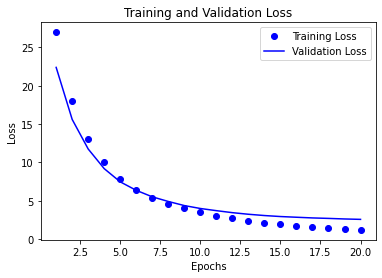

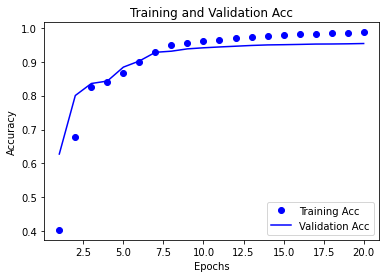

['我', '是', '中国人']
['我', '爱', '北京', '天安', '门']
['郭小美', '和', '王帅身穿', '和', '服走', '在', '大街', '上']
['李冰冰', '从', '马上', '跳', '下来']
['武汉市', '长江大桥', '发表', '重要', '讲话']
['人们', '常', '说', '生活', '是', '一', '部', '教科书', '，', '而', '血', '与', '火', '的', '战争', '更', '是', '不可多得', '的', '教科书', '，', '她', '确实', '是', '名副其实', '的', '‘', '我', '的', '大学', '’', '。']
['为', '了有效', '地解', '决“', '高', '产穷', '县”', '的', '矛盾', '，', '吉林', '省', '委', '、', '省', '政', '府', '深', '入实', '际，', '调查', '研', '究', '，确', '定', '了实', '施', '“三', '大一', '强', '”', '的', '农业', '发展', '战', '略，即', '经', '过的', '努力', '，粮', '食', '产量', '要再', '上', '两个台阶', '，畜牧', '业', '要成', '为农', '民增', '收', '的支柱产', '业', '，', '农', '副产', '品', '加工', '业要', '成为', '全']


In [9]:
train()

In [ ]:
from imp import reload
from nlp.segment import tools
from nlp.segment.tools import evaluation_seg
reload(tools)

mode = 'seg'

def evaluation():
    seg = build_segment()
    gold = data_path+"/nlp/corpus/icwb2-data/gold/msr_test_gold.utf8"
    tools.evaluation_seg(seg, gold)

In [ ]:
evaluation()

100%|██████████| 3985/3985 [09:58<00:00,  6.66it/s]

 correct : 1597.000000  0.400753  P: 0.849083  R: 0.820235
